In [1]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from google.colab.patches import cv2_imshow

# Prepare your comparison patterns
We stopped at the step of OCR in phase 1. Now, it's time to proceed. There are many methods to perform OCR, some classical, some modern. We'll do a classical approach using morphological operations and "gold" reference digit structuring elements. By seeing how well each tile matches each of the digits, we could detect the value in each tile. Note that I crafted these SEs by hand to give good results.

You see what you can do.

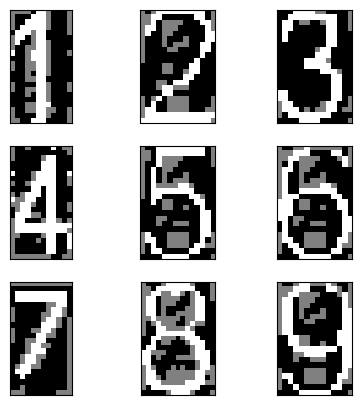

In [2]:
digit_ses = []
for i in range(9):
    se = cv2.imread(f"{i+1}.jpg", cv2.IMREAD_GRAYSCALE)
    se_canvas = np.zeros_like(se, dtype = np.int16)
    se_canvas[se < 64] = -1
    se_canvas[se > 180] = 1
    digit_ses.append(se_canvas)
_, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(digit_ses[i*3+j], cmap="gray", vmin=-1, vmax=1);
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)

# preprocessing + OCR!

Helper Functions


In [3]:
number_tiles = []
def largest_connected_component_pixels(binary_image):
    # Find contours of connected components in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to store information about the largest component
    max_pixels = 0

    # Iterate through all contours to find the largest one
    for contour in contours:
        # Calculate the area (number of pixels) of each contour
        area = cv2.contourArea(contour)

        # Update if the current contour has more pixels than the current maximum
        if area > max_pixels:
            max_pixels = area

    return max_pixels

def remove_border_collisions(image):
    # Find contours of white objects in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the image dimensions
    height, width = image.shape[:2]

    # Create a mask to store the border collisions
    border_collisions = np.zeros_like(image)

    # Iterate through contours
    for contour in contours:
        for point in contour:
            x, y = point[0]  # Extract x and y coordinates
            # Check if the point is on the border
            if x == 0 or x == width - 1 or y == 0 or y == height - 1:
                # If on the border, set the corresponding pixel in the mask to white
                cv2.drawContours(border_collisions, [contour], -1, 255, thickness=cv2.FILLED)
                break  # Exit the loop for this contour

    # Set the border collision pixels to black in the original image
    result = cv2.bitwise_and(image, cv2.bitwise_not(border_collisions))

    return result


def extract_largest_rectangle(image):
    # Find contours of white objects in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)

    # Find the minimum area bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Create a mask for the largest rectangle
    rectangle_mask = np.zeros_like(image)
    cv2.drawContours(rectangle_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Create a new blank image and draw the largest rectangle on it
    largest_rectangle_image = np.zeros_like(image)
    cv2.rectangle(largest_rectangle_image, (x, y), (x + w, y + h), 255, thickness=cv2.FILLED)

    # Bitwise AND operation to extract the largest rectangle
    extracted_rectangle = cv2.bitwise_and(rectangle_mask, largest_rectangle_image)

    return extracted_rectangle


def detect_vertical_lines_prewitt(image):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = image

    # Define the Prewitt kernel for horizontal edge detection
    prewitt_kernel = np.array([[1, 0, -1],
                               [1, 0, -1],
                               [1, 0, -1]])

    # Apply the Prewitt kernel using filter2D
    ver_edges = cv2.filter2D(gray, -1, prewitt_kernel)

    # Threshold the edges to get binary image
    # _, thresholded = cv2.threshold(horizontal_edges, 50, 255, cv2.THRESH_BINARY)

    # return thresholded
    return ver_edges

def thinning(image):
    # Convert the image to grayscale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to get a binary image (if needed)
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Apply Zhang-Suen thinning algorithm
    thin = cv2.ximgproc.thinning(binary)

    return thin

def map_values_to_range(value, input_min, input_max, map_min=0, map_max=255):
    # Mapping the value between 0 and 255
    mapped_value = ((value - input_min) / (input_max - input_min)) * map_max

    # Ensure the value is within the 0-255 range
    mapped_value = max(map_min, min(mapped_value, map_max))

    return np.int32(math.ceil(mapped_value))


def reverse_map_values(mapped_value, x, y):
    # Reversing the mapping to get the original value
    original_value = (mapped_value / 255) * (y - x) + x
    return original_value



In [4]:
# helper function to remove the shadows
class Thresh(Enum):
    OTSU = 1
    Adaptive = 2
    OTSU_and_Adaptive = 3

# changed name to 2
def shadow_removal_and_binary_threshold2(original_image, thresh_type=3):
    rgb_planes = cv2.split(original_image)
   # print(rgb_planes)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((5, 5), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 23)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
   # print(result_planes)
    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    # print("result before hist")
    # cv2_imshow(result)
    # # remove if anything goes wrong
    # result = cv2.equalizeHist(result)
    # print("result after hist")
    # cv2_imshow(result)
    # gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(result_norm, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
    out, thresholded = cv2.threshold(result_norm, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    anded_img = thresh & thresholded

    if thresh_type == 1:
        return thresholded
    elif thresh_type == 2:
        return thresh
    elif thresh_type == 3:
        return anded_img

In [5]:
number_tiles = []

for i in range(9):
    number_tiles.append([])
    for j in range(9):
        file_name = f"/content/08-MeshShayef7agaYa3am.jpg_{i}_{j}.jpg"  # Construct the file name
        #print(file_name)
        img = cv2.imread(file_name,-1)  # Read the image using OpenCV



        # Crop the image to extract the tile
        #tile = img[i * M:(i + 1) * M, j * N:(j + 1) * N]

        number_tiles[i].append(img)


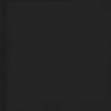

In [6]:
cv2_imshow(number_tiles[0][3])

In [7]:
#print(number_tiles)
for i in range(9):
  for j in range(9):
    #cv2_imshow(number_tiles[i][j])
    #print(number_tiles[i][j])
    # Perform histogram equalization

    kernel_size = 5  # should be an odd number
    number_tiles[i][j] = cv2.medianBlur(number_tiles[i][j], kernel_size)
    number_tiles[i][j] = shadow_removal_and_binary_threshold2(number_tiles[i][j])
    kernel_size = 5  # should be an odd number
    number_tiles[i][j] = cv2.medianBlur(number_tiles[i][j], kernel_size)
    number_tiles[i][j] = remove_border_collisions(number_tiles[i][j])
    # Apply median blur with a specified kernel size

    #cv2_imshow(number_tiles[i][j])

First, let's display the number tiles (thresholded) obtained from the image.

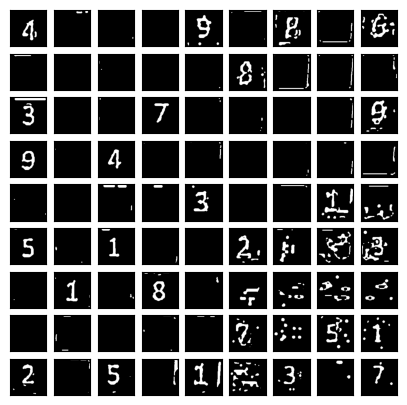

In [8]:
#tiles = [cv2.adaptiveThreshold(number_tiles[t//9][t%9], 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 10) for t in range(9*9)]
tiles = []
for i in number_tiles:
    for elem in i:
        tiles.append(elem)
_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(tiles[i*9 + j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)

Ok, so what do we do now? Let's try and see how "similar" each tile is to the corresponding structuring elements.

The gray areas (value=0) don't matter, the white areas (value=1) give you positive score if they are white in the tile, and the black areas (value=-1) give you negative score if they are black in the tile.

In [9]:
# This method will tell me if the digit exists in the image or not
# But it won't tell me where; if exists
def se_match(se, image):
    se_height, se_width = se.shape
    MAX_SCORE = np.sum(se == 1) * 4  # Total number of value=1 pixels
    score = 0
    # Go over all windows in image and get the maximum score obtained
    for y in range((image.shape[0] - se_height)):
        for x in range((image.shape[1] - se_width)):
            window = image[y:y+se_height, x:x+se_width]
            #cv2_imshow(window)
            temp_score = np.sum((window == 255) & (se == 1)) * 4  # Higher weight on white-matches
            temp_score -= np.sum((window == 0) & (se == -1))
            score = max(score, temp_score)
    return max(0, score/MAX_SCORE)

We will need to check the number of holes in the number to avoid the patterns that are in other numbers like you can find the pattern of 1 in the number 4

In [10]:
def get_num_of_holes(gray):
        #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 10)
        # Perform closing operation to fill small gaps and make relatively bigger holes
        thresh = gray
        thresh = remove_border_collisions(thresh)
        #change back to 5 if shit goes wrong
        kernel = np.ones((7, 7), np.uint8)  # Adjust the kernel size as needed
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        cv2_imshow(thresh)
        cv2_imshow(closed)
        # Find contours including internal contours
        contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a blank image to draw the hole outlines
        hole_outline = np.zeros_like(gray)

        # Count the number of holes
        num_holes = 0

        # Draw contours to fill the holes and extract their outlines
        for i, contour in enumerate(contours):
            # If the contour has a parent (-1 means no parent, so it's an external contour)
            if hierarchy[0][i][3] != -1:
                num_holes += 1
                cv2.drawContours(hole_outline, [contour], -1, (255, 255, 255), -1)  # Draw filled contour

        # Invert the filled contours
        hole_outline = cv2.bitwise_not(hole_outline)

        # Overlay the hole outlines onto the original image
        result = cv2.bitwise_and(gray, hole_outline)
        # cv2_imshow(hole_outline)
        # cv2_imshow(result)
        # cv2_imshow(result)

        # Display the result
        return num_holes

In [11]:
def compare_images(image2, image1):
    # Resize image2 to match the size of image1
    resized_image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    # Compare resized_image2 directly with image1
    score = np.sum(((image1 == 255) & (resized_image2==1)) *4)/ (image1.shape[0] * image1.shape[1])
    return score

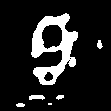

111
22


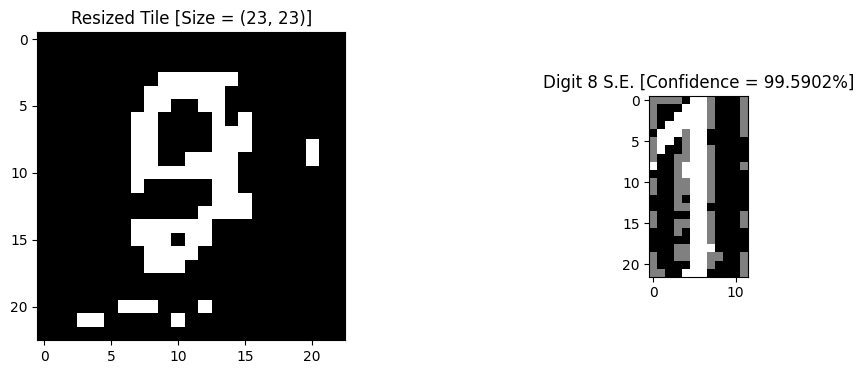

In [12]:
fig = plt.figure(figsize=(12, 4))
gs = plt.GridSpec(5, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[1:4, 1])

tile = remove_border_collisions(tiles[26])  # First tile whose value is 8 #20 is 4 # 4 is 1
cv2_imshow(tile)
se = digit_ses[0]  # S.E. for digit 8
cv2_imshow(se)
#try
kernel = np.ones((5, 5), np.uint8)  # Adjust the kernel size as needed
tile = cv2.morphologyEx(tile, cv2.MORPH_CLOSE, kernel)
#end try
max_confidence = -100
max_confidence_se = None
print(tile.shape[0])
print(se.shape[0])
# To obtain scale-invariance, let's try different input sizes
for h in range(tile.shape[0], se.shape[0], -1):
    y, x = tile.shape
    resized_tile = cv2.resize(tile, ((h*x)//y, h), cv2.INTER_NEAREST)
    resized_tile = cv2.threshold(resized_tile, 1, 255, cv2.THRESH_BINARY)[1]
    confidence = se_match(se, resized_tile)
    #confidence = compare_images(se, resized_tile)
    if confidence >= max_confidence:
        max_confidence = confidence
        max_confidence_se = se

ax1.imshow(resized_tile, cmap="gray");
ax1.set_title(f"Resized Tile [Size = {resized_tile.shape}]");
#print(max_confidence_se)
ax2.imshow(max_confidence_se, cmap="gray", vmin=-1, vmax=1);
ax2.set_title(f"Digit 8 S.E. [Confidence = {round(100*max_confidence, 4)}%]");

One more thing... How about, to improve performance, we precompute all the different sizes of the input tiles?

In [13]:
sitiles = []  # Scale-invariant tiles
y, x = tiles[0].shape
for i, tile in enumerate(tiles):
    sitiles.append([])
    for h in range(y//2, digit_ses[0].shape[0], -1):
        resized_tile = cv2.resize(tile, ((h*x)//y, h), cv2.INTER_NEAREST)
        resized_tile = cv2.threshold(resized_tile, 1, 255, cv2.THRESH_BINARY)[1]
        sitiles[i].append(resized_tile)

For even MORE performance, we'll need to parallelize our loop

In [14]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

Great... Let's do this for all tiles then!

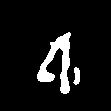

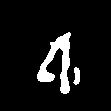

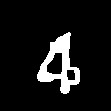

2

In [15]:
cv2_imshow(tiles[0])
get_num_of_holes(tiles[0])

In [16]:
tilenoWithResponse = {}

In [17]:
sudoku_ocr = np.zeros((9*9,))

def ocr_progress(init=False):
    if init: ocr_progress.value = 0
    else: ocr_progress.value += 1
    print(f"\r[{u'█'*ocr_progress.value}{('-'*(9*9-ocr_progress.value))}] {ocr_progress.value}/{9*9} tiles processed.", end='')



async def ocr(tileno, min_confidence):
    #print("started")
    max_confidence = -100
    max_confidence_se = None
    max_confidence_se_i = -1
    ax1 = fig.add_subplot(gs[tileno*7+1:(tileno+1)*7-1, 0]);
    ax1.set_title(f"Tile [{tileno//9}][{tileno%9}]");
    ax1.imshow(tiles[tileno], cmap="gray");
    for tile in sitiles[tileno]:
        for se_i, se in enumerate(digit_ses):
            confidence = se_match(se, tile)
            if confidence > max_confidence:
                max_confidence = confidence
                max_confidence_se = se
                max_confidence_se_i = se_i
    #print(max_confidence)
    if (max_confidence >= min_confidence):
      #if number detected if 4 or 1 check its number of holes
        if(max_confidence_se_i==3 or max_confidence_se_i==0):
            holes_num = get_num_of_holes(tiles[tileno])
            if (holes_num==1):
                max_confidence_se_i = 3
                max_confidence_se = digit_ses[max_confidence_se_i]
            else:
                max_confidence_se_i = 0
                max_confidence_se = digit_ses[max_confidence_se_i]


        # 5 or 3
        if(max_confidence_se_i == 4 or max_confidence_se_i == 2 ):
            # remove any connected white pixles with the border
            temp = remove_border_collisions(tiles[tileno])
            # close the image in case the number is cut
            kernel = np.ones((7, 7), np.uint8)  # Adjust the kernel size as needed
            temp = cv2.morphologyEx(temp, cv2.MORPH_CLOSE, kernel)
            # get the rectangle that contains the number
            temp = extract_largest_rectangle(temp)
            # get the skelton of the number (thininng)
            temp = thinning(temp)
            # get the vertical lines
            temp = detect_vertical_lines_prewitt(temp)
            # dilate the result
            size = 5
            box_kernel = np.ones((size, size), np.uint8)
            #temp = cv2.dilate(temp,box_kernel,iterations=1)
            # calculate the pixels area of the largest detected line (3 should have larger are than 5)
            res = largest_connected_component_pixels(temp)
            cv2_imshow(temp)
            print(res)
            tilenoWithResponse[tileno]=res
            if(res < 30): # mostly its 5
                max_confidence_se_i = 4
                max_confidence_se = digit_ses[max_confidence_se_i]
            elif(res >= 30): #mostly its 3
                max_confidence_se_i = 2
                max_confidence_se = digit_ses[max_confidence_se_i]


        # 6 5 and 8
        if(max_confidence_se_i == 4 or max_confidence_se_i == 5 or max_confidence_se_i == 7):

            holes_num = get_num_of_holes(tiles[tileno])
            #its 5 if it has no holes it could be 3 also so this need to be fixed (later)
            if(holes_num == 0):
                max_confidence_se_i = 4
                max_confidence_se = digit_ses[max_confidence_se_i]
                 # 5 or 3
                if(max_confidence_se_i == 4 or max_confidence_se_i == 2 ):
                    # remove any connected white pixles with the border
                    temp = remove_border_collisions(tiles[tileno])
                    # close the image in case the number is cut
                    kernel = np.ones((7, 7), np.uint8)  # Adjust the kernel size as needed
                    temp = cv2.morphologyEx(temp, cv2.MORPH_CLOSE, kernel)
                    # get the rectangle that contains the number
                    temp = extract_largest_rectangle(temp)
                    # get the skelton of the number (thininng)
                    temp = thinning(temp)
                    # get the vertical lines
                    temp = detect_vertical_lines_prewitt(temp)
                    # dilate the result
                    size = 5
                    box_kernel = np.ones((size, size), np.uint8)
                    #temp = cv2.dilate(temp,box_kernel,iterations=1)
                    # calculate the pixels area of the largest detected line (3 should have larger are than 5)
                    res = largest_connected_component_pixels(temp)
                    cv2_imshow(temp)
                    print(res)
                    tilenoWithResponse[tileno]=res
                    if(res < 28): # mostly its 5
                        max_confidence_se_i = 4
                        max_confidence_se = digit_ses[max_confidence_se_i]
                    elif(res >= 28): #mostly its 3
                        max_confidence_se_i = 2
                        max_confidence_se = digit_ses[max_confidence_se_i]


            #its 6 if it has one hole
            elif(holes_num == 1):
                max_confidence_se_i = 5
                max_confidence_se = digit_ses[max_confidence_se_i]
            #it has 2 holes then its 8
            elif(holes_num == 2):
                max_confidence_se_i = 7
                max_confidence_se = digit_ses[max_confidence_se_i]




        ax2 = fig.add_subplot(gs[tileno*7+2:(tileno+1)*7-2, 2]);
        ax2.set_title(f"S.E. [Confidence = {round(max_confidence*100, 4)}%]");
        ax2.imshow(max_confidence_se, cmap="gray");
        sudoku_ocr[tileno] = max_confidence_se_i + 1
    ocr_progress()

[---------------------------------------------------------------------------------] 0/81 tiles processed.

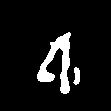

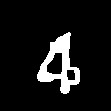

[██████---------------------------------------------------------------------------] 6/81 tiles processed.

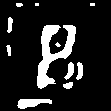

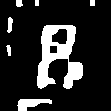

[████████-------------------------------------------------------------------------] 8/81 tiles processed.

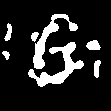

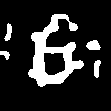

[██████████████-------------------------------------------------------------------] 14/81 tiles processed.

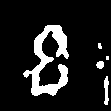

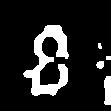

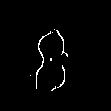

29.5
[██████████████████---------------------------------------------------------------] 18/81 tiles processed.

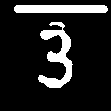

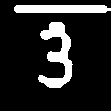

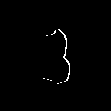

30.0
[█████████████████████████████----------------------------------------------------] 29/81 tiles processed.

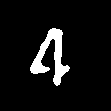

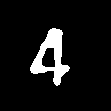

[████████████████████████████████████████-----------------------------------------] 40/81 tiles processed.

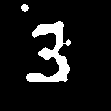

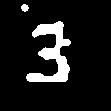

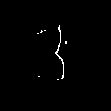

26.0
[███████████████████████████████████████████--------------------------------------] 43/81 tiles processed.

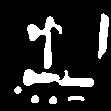

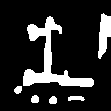

[█████████████████████████████████████████████------------------------------------] 45/81 tiles processed.

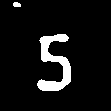

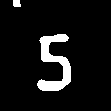

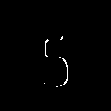

15.0
[███████████████████████████████████████████████----------------------------------] 47/81 tiles processed.

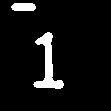

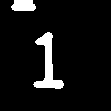

[███████████████████████████████████████████████████------------------------------] 51/81 tiles processed.

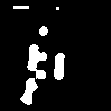

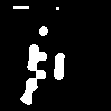

[████████████████████████████████████████████████████-----------------------------] 52/81 tiles processed.

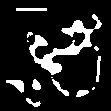

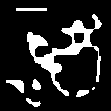

[█████████████████████████████████████████████████████----------------------------] 53/81 tiles processed.

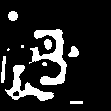

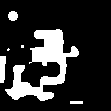

[███████████████████████████████████████████████████████--------------------------] 55/81 tiles processed.

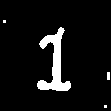

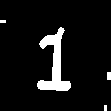

[█████████████████████████████████████████████████████████------------------------] 57/81 tiles processed.

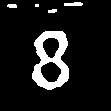

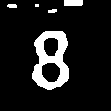

[███████████████████████████████████████████████████████████----------------------] 59/81 tiles processed.

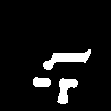

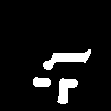

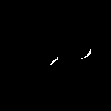

8.5
[█████████████████████████████████████████████████████████████--------------------] 61/81 tiles processed.

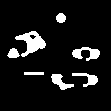

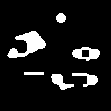

[██████████████████████████████████████████████████████████████-------------------] 62/81 tiles processed.

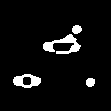

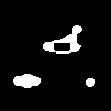

[██████████████████████████████████████████████████████████████████████-----------] 70/81 tiles processed.

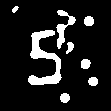

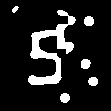

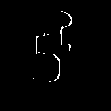

13.5
[███████████████████████████████████████████████████████████████████████----------] 71/81 tiles processed.

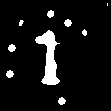

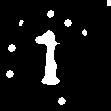

[██████████████████████████████████████████████████████████████████████████-------] 74/81 tiles processed.

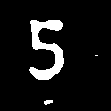

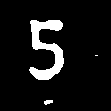

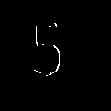

15.5
[███████████████████████████████████████████████████████████████████████████------] 75/81 tiles processed.

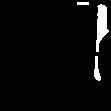

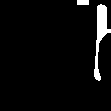

[████████████████████████████████████████████████████████████████████████████-----] 76/81 tiles processed.

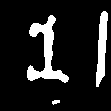

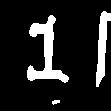

[█████████████████████████████████████████████████████████████████████████████----] 77/81 tiles processed.

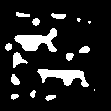

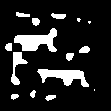

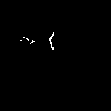

13.0
[██████████████████████████████████████████████████████████████████████████████---] 78/81 tiles processed.

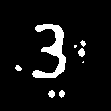

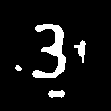

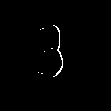

29.0
[█████████████████████████████████████████████████████████████████████████████████] 81/81 tiles processed.

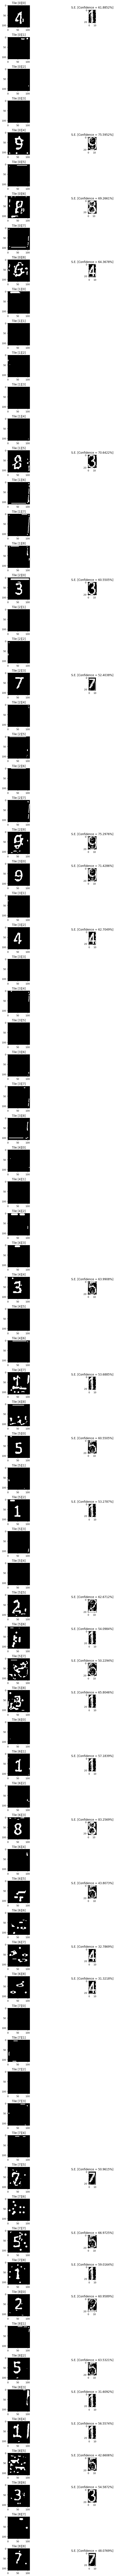

In [18]:
fig = plt.figure(figsize=(8, 200))
gs = plt.GridSpec(7*9*9, 3)
ocr_progress(init=True)  # Initial progress (0 tiles processed)
await asyncio.wait(
    [asyncio.create_task(ocr(tileno, 0.28)) for tileno in range(9*9)]
);


Take the global optimal threshold and differentiate 5 and 3


In [19]:

def three_or_five():
      values_array = np.array(list(tilenoWithResponse.values()),dtype=np.int32)
      max_value = values_array.max()
      min_value = values_array.min()
      new_array = np.zeros((values_array.shape[0],), dtype=np.int32)
      for i in range(new_array.shape[0]):
          new_array[i] = map_values_to_range(values_array[i], min_value, max_value)

      new_array = np.uint8(new_array)
      out, thresholded = cv2.threshold(new_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      out  = reverse_map_values(out, min_value, max_value) +1
      print("Otsu's threshold value:", out)
      for key, value in tilenoWithResponse.items():
          if tilenoWithResponse[key] < out:
              sudoku_ocr[key] = 5
          else:
              sudoku_ocr[key] = 3


In [20]:
print(tilenoWithResponse)

{14: 29.5, 18: 30.0, 40: 26.0, 45: 15.0, 59: 8.5, 70: 13.5, 74: 15.5, 77: 13.0, 78: 29.0}


In [21]:
import math
three_or_five()
print(tilenoWithResponse)
print(sudoku_ocr)

Otsu's threshold value: 16.07450980392157
{14: 29.5, 18: 30.0, 40: 26.0, 45: 15.0, 59: 8.5, 70: 13.5, 74: 15.5, 77: 13.0, 78: 29.0}
[1. 0. 0. 0. 9. 0. 8. 0. 4. 0. 0. 0. 0. 0. 3. 0. 0. 0. 3. 0. 0. 7. 0. 0.
 0. 0. 9. 9. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 1. 0. 5. 0. 1.
 0. 0. 2. 1. 6. 1. 0. 1. 0. 8. 0. 5. 0. 4. 4. 0. 0. 0. 0. 0. 7. 0. 5. 1.
 2. 0. 5. 1. 1. 5. 3. 0. 7.]


*italicized text*(tbh I don't believe this even worked lol)

# Et voila!

In [22]:
def textize_sudoku(board):
    sudoku_ocr_text = ''
    for i, row in enumerate(board):
        sudoku_ocr_text += ' ├───────────┼───────────┼───────────┤ ' if (i%3 == 0) else ' │           │           │           │ '
        sudoku_ocr_text += '\n'
        sudoku_ocr_text += ' │ '
        for j, cell in enumerate(row): sudoku_ocr_text += f"{cell if cell != 0 else ' '} {' ' if (j%3 != 2) else '│'} "
        sudoku_ocr_text += '\n'
    sudoku_ocr_text += ' ├───────────┼───────────┼───────────┤ '
    return sudoku_ocr_text

In [23]:
def find_next_empty_cell(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                return (i, j)
    return None

def is_valid(board, num, row, col):
    for i in range(9):  # row and column checks
        if board[row][i] == num and col != i: return False
        if board[i][col] == num and row != i: return False

    # Check box
    box_row = (row // 3) * 3
    box_col = (col // 3) * 3
    for i in range(box_row, box_row + 3):
        for j in range(box_col, box_col + 3):
            if board[i][j] == num and (i, j) != (row, col):
                return False
    return True

def solve(board):
    empty_cell_pos = find_next_empty_cell(board)
    if empty_cell_pos == None: return True  # No empty cells; board is solved
    row, col = empty_cell_pos
    for num in range(1, 10):
        if is_valid(board, num, row, col):  # Find a valid value to proceed with
            board[row][col] = num  # 'num' seems valid (so far), proceed with it
            if solve(board): return True  # Try to solve the rest of the board
            board[row][col] = 0  # Couldn't continue? Then 'num' was wrong! :(
    return False

def solve_sudoku(board):
    sudoku_to_solve = np.copy(board)
    solve(sudoku_to_solve)
    solved_sudoku = []
    for i in range(9):
        solved_sudoku.append([])
        for j in range(9):
            solved_sudoku[i].append("\033[1m"+str(board[i][j])+"\033[0m" if (board[i][j] != 0) else "\033[91m"+str(sudoku_to_solve[i][j])+"\033[0m")
    return solved_sudoku

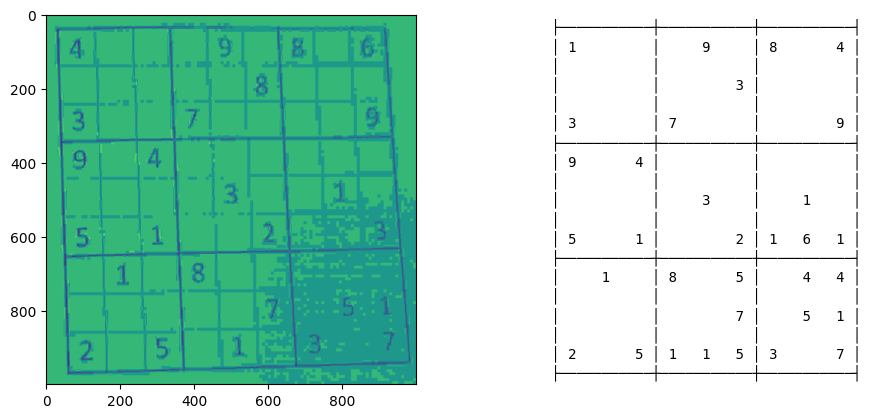

In [24]:
file_name = f"/content/08-MeshShayef7agaYa3am.jpg"  # Construct the file name
        #print(file_name)
img = cv2.imread(file_name,0)  # Read the image using OpenCV
plt.imshow(img);
plt.figtext(1, 0.125, textize_sudoku(sudoku_ocr.reshape((9, 9)).astype(int)), fontfamily='monospace');

In [25]:
print(textize_sudoku(solve_sudoku(sudoku_ocr.reshape((9, 9)).astype(int))))

 ├───────────┼───────────┼───────────┤ 
 │ 1   0   0 │ 0   9   0 │ 8   0   4 │ 
 │           │           │           │ 
 │ 0   0   0 │ 0   0   3 │ 0   0   0 │ 
 │           │           │           │ 
 │ 3   0   0 │ 7   0   0 │ 0   0   9 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 9   0   4 │ 0   0   0 │ 0   0   0 │ 
 │           │           │           │ 
 │ 0   0   0 │ 0   3   0 │ 0   1   0 │ 
 │           │           │           │ 
 │ 5   0   1 │ 0   0   2 │ 1   6   1 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 0   1   0 │ 8   0   5 │ 0   4   4 │ 
 │           │           │           │ 
 │ 0   0   0 │ 0   0   7 │ 0   5   1 │ 
 │           │           │           │ 
 │ 2   0   5 │ 1   1   5 │ 3   0   7 │ 
 ├───────────┼───────────┼───────────┤ 
